<a href="https://colab.research.google.com/github/IsmailHaris/DLcourse/blob/master/Projet_DL_Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Le but de ce travail est d'utiliser les différents algorithmes de Deep Learning pour la prédiction du prix du Bitcoin. Nous allons comparer le MultiLayerPerceptron  MLP, Multiple 1D CNN, le LSTM, et le GRU. 
Ce travail se base sur un papier de l'University of California Berkeley ('A Gated Recurrent Unit Approach to Bitcoin Price Prediction') publié en Décembre 2019.
Le travail m'a permis de comprendre le concepts de ces différentes méthodes et comment les customiser pour obtenir des résultats optimaux. 
Je ne détaillerai pas ici le principe de ces différents algorithmes. 

In [1]:
import pandas as pd
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns



Using TensorFlow backend.


In [2]:
print('Using python {}.{}, with modules versions'.format(sys.version_info.major, sys.version_info.minor))
print('-'*40)
print('numpy == {}'.format(np.__version__))
print('torch == {}'.format(tf.__version__))  # please use version 1.0 or above

Using python 3.6, with modules versions
----------------------------------------
numpy == 1.18.2
torch == 1.15.0


Load Dataset

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Bitcoindata.csv to Bitcoindata.csv


In [141]:
data = pd.read_csv("Bitcoindata.csv", sep=';') 
data.head()


,Date,Bitcoin Core (BTC) Price,Money Supply,Price Volatility,Daily Transactions,Block Size,Transaction Fees,Inflation Rate
0,06/02/2011,0.89,5321500.0,164.844710,876,1586,0.178263,174.722
1,07/02/2011,0.89,5330350.0,164.987700,861,1685,0.101126,173.646
2,08/02/2011,0.88,5340500.0,165.328338,888,1316,0.315472,172.767
3,09/02/2011,0.91,5348900.0,164.880682,879,1615,0.177370,171.759
4,10/02/2011,1.03,5358500.0,167.764321,1246,1973,0.065517,171.090


Je vais donner une brève explication de chaque terme constituant mon dataset. 
donner les dates, explications des termes, la source, exogene, endogene, 

In [142]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 8 columns):
Date                        3333 non-null object
Bitcoin Core (BTC) Price    3333 non-null float64
Money Supply                3333 non-null float64
Price Volatility            3333 non-null float64
Daily Transactions          3333 non-null int64
Block Size                  3333 non-null int64
Transaction Fees            3333 non-null float64
Inflation Rate              3333 non-null float64
dtypes: float64(5), int64(2), object(1)
memory usage: 208.4+ KB


Voyons ce à quoi ressemble le prix du Bitcoin au cours du temps

In [143]:
btc_trace = go.Scatter(x=data['Date'], y=data['Bitcoin Core (BTC) Price'], name= 'Price')
py.iplot([btc_trace])

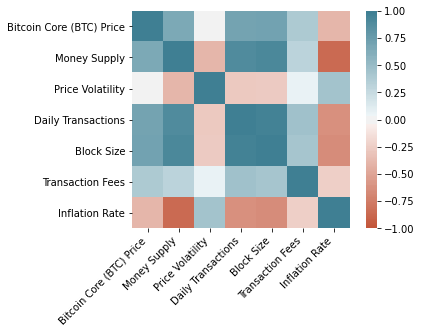

In [159]:
#Let's have a look at the correlation between the features and the Bitcoin price
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=300),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Preprocessing the data

In [0]:
#1 There are no NaNs to fill. 
#2 There are no categorical features to do one hot encoding
#Je vais diviser mon Dataset en 3 parties : Training set, validation set et test set
#le training set va du 06 Février 2011 au 31 Décembre 2018
#le validation set va du 01 Janvier 2019 au 22 Septembre 2019
#le test set va du 23 Septembre 2019 au 22 Mars 2020


In [0]:
data['Date'] = pd.to_datetime(data['Date'])
data_train = data.loc[data['Date']<='31-12-2018']
data_validation = data.iloc[2886:3151]
data_test = data.iloc[3151:]


In [145]:
data_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2886 entries, 0 to 2885
Data columns (total 8 columns):
Date                        2886 non-null datetime64[ns]
Bitcoin Core (BTC) Price    2886 non-null float64
Money Supply                2886 non-null float64
Price Volatility            2886 non-null float64
Daily Transactions          2886 non-null int64
Block Size                  2886 non-null int64
Transaction Fees            2886 non-null float64
Inflation Rate              2886 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 202.9 KB


In [146]:
data_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 3151 to 3332
Data columns (total 8 columns):
Date                        182 non-null datetime64[ns]
Bitcoin Core (BTC) Price    182 non-null float64
Money Supply                182 non-null float64
Price Volatility            182 non-null float64
Daily Transactions          182 non-null int64
Block Size                  182 non-null int64
Transaction Fees            182 non-null float64
Inflation Rate              182 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 11.5 KB


In [147]:
data_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 2886 to 3150
Data columns (total 8 columns):
Date                        265 non-null datetime64[ns]
Bitcoin Core (BTC) Price    265 non-null float64
Money Supply                265 non-null float64
Price Volatility            265 non-null float64
Daily Transactions          265 non-null int64
Block Size                  265 non-null int64
Transaction Fees            265 non-null float64
Inflation Rate              265 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 16.7 KB


In [0]:
#je drop la date de tous les dataframes
data_train = data_train.drop(columns = ['Date'])
data_test = data_test.drop(columns = ['Date'])
data_validation = data_validation.drop(columns = ['Date'])


In [0]:
training_set = data_train.values
validation_set = data_validation.values
test_set = data_test.values


In [0]:
# Nous passons maintenant à la normalisation. Pour cela je vais utiliser le minmaxScaler de Scikit Learn
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(training_set)
training_set = scaler.transform(training_set)
validation_set = scaler.transform(training_set) #même la partie validation & test est normalisé selon les données de training
test_set = scaler.transform(training_set)


In [0]:
#Let us extract from this datasets numpy arrays that contains training sets, test sets and validation sets

X_train = training_set[:,1:7]
y_train = training_set[:,0]

X_validation = validation_set[:,1:7]
y_validation = validation_set[:,0]


X_test = test_set[:,1:7]
y_test = test_set[:,0]


In [152]:
print(X_train.shape, X_train.mean(), X_train.var())
print(y_train.shape, y_train.mean(), y_train.var())
print(X_validation.shape, X_validation.mean(), X_validation.var())
print(y_validation.shape,y_validation.mean(), y_validation.var())
print(X_test.shape, X_test.mean(), X_test.var())
print(y_test.shape, y_test.mean(), y_test.var())

(2886, 6) 0.2787942409961505 0.08473252758685791
(2886,) 0.08605353219101022 0.025152951535448765
(2886, 6) -0.08440110541695352 0.02532405588305796
(2886,) -3.146696836346266e-05 6.828131395235948e-11
(2886, 6) -0.08440110541695352 0.02532405588305796
(2886,) -3.146696836346266e-05 6.828131395235948e-11


Now that our Data is ready, let's begin with the MultiLayer Perceptron MLP Regressor. 

Le papier auquel je me réfère suggère de prendre 2 hidden layers, de 25 nodes chacun, une fonction d'activation tanh, l'optimize solver Adam, un batch size de 125, un learning rate par défaut et adaptive. 
Je vais lancer un gridSearch pour pour determiner les paramètres optimaux car les valeurs des learning hyper-parameters peuvent drastiquement changer les résultats du learning.Il est essentiel d'essayer de les optimiser.Nous allons pour cela utiliser une cross validation car c'est la méthode la plus robuste pour déterminer les hyperparamètres optimaux. Je vais donc utiliser un GridSearch de ScikitLearn.

Voici certains points importants : 

Pour le nombre max_iter, qui correspond au nomdre de training epochs, au lieu de l'optimiser, je prefère prendre un grand nombre de epochs (500) et d'activer l'early stopping. Si le nombre d'iterations est trop grand, on risque l'overfitting, s'il est trop petit, l'entrainement risque de ne pas converger.
Je rappelle que 1 epoch veut dire que tout le training set est étudié une fois. et iterations correspond au nombre de batch pour completer les epoch.

Le gridsearch concernera : le nombre de hidden layer, la taille de chaque hidden layer, le learning rate init, momentum, alpha. 

Le batch size est choisi égal à 100. Je vais accepter le shuffle de mes datas (shuffle = True). Cela peut paraitre incohérent lorsqu'on étudie des série temporelles, mais d'après mes recherches, il est conseillé de shuffle ses données pour que le NN n'aprennent pas l'ordre. Par ailleurs, ce ne sont pas les datas qui sont mélangées mais les batch, donc pas de soucis. C'est seulement l'ordre dans lequel ces séquences sont entrainées qui est mélangé, les séquences, elles, restent intactes. 

Si le nombre de hidden layer est trop élevé, il y a un risque d'overfitting. Généralement, seule un hidden layer est suffisant (Cybenko Theorem). 

Pour la fonction d'activation, j'ai pensé d'abord à utiliser ReLu car elle permet d'empêcher le gradient vanishing. Mais le papier de référence suggère plutôt d'utiliser tanH car certes elle souffre de la disparition du gradient, mais ils expliquent que " the second derivative can sustain for a long time before converging to zero, unlike ReLu, which improves the model prediction". 

Le learning rate initial impacte toujours l'outcome du training ( trop petit = le training peut rester bloquer dans un minimum local, trop grand = possibilité de non convergence) 
Le learning rate est adaptive : ‘adaptive’ keeps the learning rate constant to ‘learning_rate_init’ as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if ‘early_stopping’ is on, the current learning rate is divided by 5.

To avoid this staying stuck in a local minimum, we use a momentum term in the objective function, which is a value between 0 and 1 that increases the size of the steps taken towards the minimum by trying to jump from a local minima. If the momentum term is large then the learning rate should be kept smaller. A large value of momentum also means that the convergence will happen fast. But if both the momentum and learning rate are kept at large values, then you might skip the minimum with a huge step. A small value of momentum cannot reliably avoid local minima, and can also slow down the training of the system. Momentum also helps in smoothing out the variations, if the gradient keeps changing direction. A right value of momentum can be either learned by hit and trial or through cross-validation.

Alpha correspond à la régularisation L2 des poids. C'est une manière d'éviter l'overfitting. 



In [165]:
from sklearn.neural_network import MLPRegressor

#pour les hidden layer, ca me dira si je prends un ou deux layers, et combien de neurones dans chaque hidden layer
param_grid = [
  {'hidden_layer_sizes': [(10,), (10,10), (20,), (20,20), (25,), (25,25), (30,), (30,30)], 
   'learning_rate_init':[0.003, 0.01, 0.03, 0.1],
   'alpha': [0.00001, 0.0001, 0.001],
    'momentum': [0.1, 0.5, 0.8, 0.9]
 }]

print(param_grid)


[{'hidden_layer_sizes': [(10,), (10, 10), (20,), (20, 20), (25,), (25, 25), (30,), (30, 30)], 'learning_rate_init': [0.003, 0.01, 0.03, 0.1], 'alpha': [1e-05, 0.0001, 0.001], 'momentum': [0.1, 0.5, 0.8, 0.9]}]


In [167]:
# Cross-validation (5 folds) grid-search (the scoring is taken to be the root mean squared error)

from sklearn.model_selection import GridSearchCV
mlp = GridSearchCV(MLPRegressor(hidden_layer_sizes=(1, ), activation='tanh', solver='adam', 
                    alpha=0.0000001, batch_size=100, learning_rate='adaptive', learning_rate_init=0.005, 
                    power_t=0.5, max_iter=500, shuffle=True, random_state=11, tol=0.00001, 
                    verbose=True, warm_start=False, momentum=0.8, nesterovs_momentum=True, 
                    early_stopping=True, validation_fraction=0.2, 
                    beta_1=0.9, beta_2=0.999, epsilon=1e-08), param_grid, cv=5, scoring='neg_root_mean_squared_error')
print(mlp)

GridSearchCV(cv=5, error_score=nan,
             estimator=MLPRegressor(activation='tanh', alpha=1e-07,
                                    batch_size=100, beta_1=0.9, beta_2=0.999,
                                    early_stopping=True, epsilon=1e-08,
                                    hidden_layer_sizes=(1,),
                                    learning_rate='adaptive',
                                    learning_rate_init=0.005, max_fun=15000,
                                    max_iter=500, momentum=0.8,
                                    n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_state=11, shuf...
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [1e-05, 0.0001, 0.001],
                          'hidden_layer_sizes': [(10,), (10, 10), (20,),
                                                 (20, 20), 

In [0]:
mlp.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
print(mlp.best_params_)
print()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Validation score: 0.685872
Iteration 15, loss = 0.00437631
Validation score: 0.585215
Iteration 16, loss = 0.00457701
Validation score: 0.735485
Iteration 17, loss = 0.00368377
Validation score: 0.763476
Iteration 18, loss = 0.00344563
Validation score: 0.756879
Iteration 19, loss = 0.00333407
Validation score: 0.762869
Iteration 20, loss = 0.00440097
Validation score: 0.790985
Iteration 21, loss = 0.00334427
Validation score: 0.795391
Iteration 22, loss = 0.00282650
Validation score: 0.730484
Iteration 23, loss = 0.00274670
Validation score: 0.805338
Iteration 24, loss = 0.00246693
Validation score: 0.788081
Iteration 25, loss = 0.00247126
Validation score: 0.781199
Iteration 26, loss = 0.00241019
Validation score: 0.807824
Iteration 27, loss = 0.00305655
Validation score: 0.847828
Iteration 28, loss = 0.00247782
Validation score: 0.853940
Iteration 29, loss = 0.00221119
Validation score: 0.854604
Iteration 

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning:

Training interrupted by user.



Iteration 6, loss = 0.00859195
Validation score: 0.351665
Iteration 7, loss = 0.00781104
Validation score: 0.399058
Iteration 8, loss = 0.00716590
Validation score: 0.483757
Iteration 9, loss = 0.00709784
Validation score: 0.365216
Iteration 10, loss = 0.00692358
Validation score: 0.609643
Iteration 11, loss = 0.00612429
Validation score: 0.652065
Iteration 12, loss = 0.00579544
Validation score: 0.558112
Iteration 13, loss = 0.00622208
Validation score: 0.573418
Iteration 14, loss = 0.00497427
Validation score: 0.703517
Iteration 15, loss = 0.00573814
Validation score: 0.502257
Iteration 16, loss = 0.00644195
Validation score: 0.703548
Iteration 17, loss = 0.00615762
Validation score: 0.565311
Iteration 18, loss = 0.00691209
Validation score: 0.687956
Iteration 19, loss = 0.00523662
Validation score: 0.684763
Iteration 20, loss = 0.00597954
Validation score: 0.684105
Iteration 21, loss = 0.00864740
Validation score: 0.715306
Iteration 22, loss = 0.00837696
Validation score: 0.625357
I

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning:

Training interrupted by user.



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Validation score: 0.575573
Iteration 18, loss = 0.00676317
Validation score: 0.565717
Iteration 19, loss = 0.00684400
Validation score: 0.548064
Iteration 20, loss = 0.00682999
Validation score: 0.587690
Iteration 21, loss = 0.00660892
Validation score: 0.586321
Iteration 22, loss = 0.00658920
Validation score: 0.559095
Iteration 23, loss = 0.00677944
Validation score: 0.590097
Iteration 24, loss = 0.00661877
Validation score: 0.588667
Iteration 25, loss = 0.00647659
Validation score: 0.567584
Iteration 26, loss = 0.00677131
Validation score: 0.595400
Iteration 27, loss = 0.00641309
Validation score: 0.594585
Iteration 28, loss = 0.00635919
Validation score: 0.603080
Iteration 29, loss = 0.00632870
Validation score: 0.598550
Iteration 30, loss = 0.00636335
Validation score: 0.610095
Iteration 31, loss = 0.00626984
Validation score: 0.597059
Iteration 32, loss = 0.00631333
Validation score: 0.600923
Iteration 